In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Upon Checking, a lot of datasets on Kaggle contain the same data data, these are some examples:

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

https://www.kaggle.com/datasets/abhishek14398/sms-spam-collection

https://www.kaggle.com/datasets/marslinoedward/sms-spam-dataset

https://archive.ics.uci.edu/dataset/228/sms+spam+collection


So we will use the following unique datasets:

https://www.kaggle.com/datasets/bwandowando/philippine-spam-sms-messages

https://www.kaggle.com/datasets/scottleechua/ph-spam-marketing-sms-w-timestamps

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

https://www.kaggle.com/datasets/vivekchutke/spam-ham-sms-dataset

https://www.kaggle.com/datasets/assumewisely/sms-spam-collection


# Data Wrangling

#### Read and Wrangle Dataset : https://www.kaggle.com/datasets/bwandowando/philippine-spam-sms-messages

In [4]:
df = pd.read_csv('./data/bwandowando-philippine-spam-sms-messages/SPAM_SMS.csv')
print(df.head()) 

   Unnamed: 0 masked_celphone_number                hashed_celphone_number  \
0           0          +63960****373  91caa5d6-1f97-3a2d-982b-5b0c021632ab   
1           1          +63981****852  f66589b7-4e6a-33ba-b7c5-d0dacb48552b   
2           2          +63946****113  1f332ce5-618e-32e6-b2ab-8e567917aeef   
3           3          +63950****934  5e6fcdc3-b2b8-3f71-b411-cacb8d40a0b9   
4           4          +63960****401  aafa248f-04ef-3005-a672-db79286919ee   

                      date                                               text  \
0  2022-11-12 14:02:10.079  Welcome ! your have P1222 for S!ot , \nWeb: 11...   
1  2022-11-12 14:33:48.916  My god, at least 999P rewards waiting for you\...   
2  2022-11-13 23:03:15.023  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...   
3  2022-11-14 00:07:18.715  <REAL NAME>! Today, you can win the iphone14PR...   
4  2022-11-15 02:28:56.636  Welcome ! your have P1222 for S!ot , \nWeb: gr...   

  carrier  
0   Smart  
1   Smart  
2     TN

In [5]:

df.drop(columns=['Unnamed: 0','masked_celphone_number','hashed_celphone_number', 'date', 'carrier'], inplace=True)
df['spam_tag'] = True
print(df.head())
print(df.describe())

                                                text  spam_tag
0  Welcome ! your have P1222 for S!ot , \nWeb: 11...      True
1  My god, at least 999P rewards waiting for you\...      True
2  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...      True
3  <REAL NAME>! Today, you can win the iphone14PR...      True
4  Welcome ! your have P1222 for S!ot , \nWeb: gr...      True
                              text spam_tag
count                          619      619
unique                         564        1
top     <<Content not supported.>>     True
freq                            13      619


#### Read and Wrangle Dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [6]:
df2 = pd.read_csv('data//uciml-sms-spam-collection-dataset/spam.csv',encoding='latin1')
print(df2.head()) 

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [7]:
def boolize(row):
    return False if row['v1'] == 'ham' else True


In [8]:
df2['spam_tag'] = df2.apply(boolize, axis=1)
df2.rename(columns={'v2':'text'}, inplace=True)
df2 = df2[['spam_tag', 'text']]
print(df2.head()) 
print(df2.describe())

   spam_tag                                               text
0     False  Go until jurong point, crazy.. Available only ...
1     False                      Ok lar... Joking wif u oni...
2      True  Free entry in 2 a wkly comp to win FA Cup fina...
3     False  U dun say so early hor... U c already then say...
4     False  Nah I don't think he goes to usf, he lives aro...
       spam_tag                    text
count      5572                    5572
unique        2                    5169
top       False  Sorry, I'll call later
freq       4825                      30


#### Read and Wrangle Dataset: https://www.kaggle.com/datasets/scottleechua/ph-spam-marketing-sms-w-timestamps

In [9]:
df3 = pd.read_csv('data/scottleechua-ph-spam-marketing-sms-w-timestamps/text-messages.csv')
print(df3.head()) 
print(df3['category'].unique()) 

         date-received            date-read         sender category  \
0  2024-02-05 18:11:17  2024-02-05 18:11:24  +6390998***20     spam   
1  2023-03-28 16:28:37  2023-03-28 16:28:48          GCash      ads   
2  2023-03-29 16:45:31  2023-03-29 16:45:38          GCash   notifs   
3  2023-03-29 17:17:32  2023-03-29 17:17:43          GCash   notifs   
4  2023-03-30 10:16:02  2023-03-30 10:16:03          GCash      OTP   

                                                text  
0  Make money while watching YouTube, earn 500P p...  
1  Get up to P125K extra funds for emergencies wi...  
2                                         <REDACTED>  
3                                         <REDACTED>  
4                                         <REDACTED>  
['spam' 'ads' 'notifs' 'OTP' 'gov']


In [10]:
def is_spam(x):
    return True if x['category'] == 'spam' else False

In [11]:
df3['spam_tag'] = df3.apply(is_spam, axis=1)
df3 = df3[['text', 'spam_tag']]
df3 = df3.drop(df3[df3['text']=='<REDACTED>'].index)
print(df3.head())
print(df3.describe())

                                                 text  spam_tag
0   Make money while watching YouTube, earn 500P p...      True
1   Get up to P125K extra funds for emergencies wi...     False
9   G to upgrade your home! Just use GCredit to pa...     False
10  Good news! You can still pay with GGives at yo...     False
11  Get up to P125K extra funds for emergencies wi...     False
                                                     text spam_tag
count                                                 898      898
unique                                                750        2
top     Pwede ng ma-access ang iba't ibang government ...     True
freq                                                   23      473


#### Read and Wrangle Dataset: https://www.kaggle.com/datasets/vivekchutke/spam-ham-sms-dataset

In [12]:
df4 = pd.read_csv('data/vivekchutke-spam-ham-sms-dataset/sms_spam.csv')
df4['spam_tag'] = df4.apply(lambda x: True if x['type'] == 'spam' else False, axis=1)
df4 = df4[['spam_tag','text']]
print(df4.head()) 
# print(df4['category'].unique()) 

   spam_tag                                               text
0     False  Hope you are having a good week. Just checking in
1     False                            K..give back my thanks.
2     False        Am also doing in cbe only. But have to pay.
3      True  complimentary 4 STAR Ibiza Holiday or £10,000 ...
4      True  okmail: Dear Dave this is your final notice to...


#### Read and Wrangle Dataset: https://www.kaggle.com/datasets/assumewisely/sms-spam-collection

In [13]:
df5 = pd.read_csv('data/assumewisely-sms-spam-collection/SMSSpamCollection.tsv', delimiter='\t', names=['spam_tag', 'text'])
df5['spam_tag'] = df5.apply(lambda x: True if x['spam_tag'] == 'spam' else False, axis=1)
# df5 = df4[['spam_tag','text']]
print(df5.head()) 

   spam_tag                                               text
0     False  I've been searching for the right words to tha...
1      True  Free entry in 2 a wkly comp to win FA Cup fina...
2     False  Nah I don't think he goes to usf, he lives aro...
3     False  Even my brother is not like to speak with me. ...
4     False                I HAVE A DATE ON SUNDAY WITH WILL!!


#### Combine Datasets and Apply Preprocessing

In [14]:
dataset = pd.concat([df,df2,df3, df4,df5])
# print(dataset['spam_tag'].head())
print(dataset.size)

36432


In [15]:
def preprocess_text(text):
    words = word_tokenize(text) #Tokenization
    words = [word.lower() for word in words if word.isalnum()] #to Lowercase
    words = [word for word in words if word not in stopwords.words("english")] #Remove Stopwords
    return " ".join(words) #Concate tokens

In [16]:
dataset['text'] = dataset['text'].apply(preprocess_text)
dataset = dataset.sample(frac=1) # shuffle the dataset
print(dataset.head())
print(dataset.describe())


                                                   text  spam_tag
1341                           somewhere fredericksburg     False
567   anyways go gym whatever love smiles hope ok go...     False
4456  welcome msg free giving free calling 087198398...      True
5081                 sorry missed call please call back     False
3612                 actually getting ready leave house     False
                    text spam_tag
count              18216    18216
unique              6944        2
top     sorry call later    False
freq                  90    14884


### One-Hot the Dataset

In [17]:
def tokenize(row):
    # print(f'{row["text"]}\n\n')
    lst = row['text'].split()
    ones = [True for item in lst]
    zipped = dict(zip(lst,ones))
    # print(zipped)
    return zipped

In [18]:
one_hot = dataset.apply(tokenize, axis=1, result_type='expand')
print(one_hot.head())
dataset_oh = pd.concat([dataset, one_hot], axis=1)

     somewhere fredericksburg anyways    go   gym whatever  love smiles  hope  \
1341      True           True     NaN   NaN   NaN      NaN   NaN    NaN   NaN   
567        NaN            NaN    True  True  True     True  True   True  True   
4456       NaN            NaN     NaN  True   NaN      NaN   NaN    NaN   NaN   
5081       NaN            NaN     NaN   NaN   NaN      NaN   NaN    NaN   NaN   
3612       NaN            NaN     NaN   NaN   NaN      NaN   NaN    NaN   NaN   

        ok  ... iphone14promax  ton heåõs p888 transacting  pot concerts uaap  \
1341   NaN  ...            NaN  NaN   NaN  NaN         NaN  NaN      NaN  NaN   
567   True  ...            NaN  NaN   NaN  NaN         NaN  NaN      NaN  NaN   
4456   NaN  ...            NaN  NaN   NaN  NaN         NaN  NaN      NaN  NaN   
5081   NaN  ...            NaN  NaN   NaN  NaN         NaN  NaN      NaN  NaN   
3612   NaN  ...            NaN  NaN   NaN  NaN         NaN  NaN      NaN  NaN   

      pvl 1859p  
1341  Na

In [19]:
dataset_oh.fillna(False, inplace=True)
print(dataset_oh.head())

                                                   text  spam_tag  somewhere  \
1341                           somewhere fredericksburg     False       True   
567   anyways go gym whatever love smiles hope ok go...     False      False   
4456  welcome msg free giving free calling 087198398...      True      False   
5081                 sorry missed call please call back     False      False   
3612                 actually getting ready leave house     False      False   

      fredericksburg  anyways     go    gym  whatever   love  smiles  ...  \
1341            True    False  False  False     False  False   False  ...   
567            False     True   True   True      True   True    True  ...   
4456           False    False   True  False     False  False   False  ...   
5081           False    False  False  False     False  False   False  ...   
3612           False    False  False  False     False  False   False  ...   

      iphone14promax    ton  heåõs   p888  transacting  

In [20]:
# print(len(dataset_oh.columns))
# print(len(set(dataset_oh.columns)))
# print(dataset_oh)

#### Extract the Features X and Target Y

In [21]:
features = [x for x in dataset_oh.columns if x not in ['spam_tag','text']]
print(f'features length={len(features)}')

features length=10043


In [22]:
Y = dataset_oh['spam_tag']
X = dataset_oh[features]
print(X.head())
print(Y.head())

      somewhere  fredericksburg  anyways     go    gym  whatever   love  \
1341       True            True    False  False  False     False  False   
567       False           False     True   True   True      True   True   
4456      False           False    False   True  False     False  False   
5081      False           False    False  False  False     False  False   
3612      False           False    False  False  False     False  False   

      smiles   hope     ok  ...  iphone14promax    ton  heåõs   p888  \
1341   False  False  False  ...           False  False  False  False   
567     True   True   True  ...           False  False  False  False   
4456   False  False  False  ...           False  False  False  False   
5081   False  False  False  ...           False  False  False  False   
3612   False  False  False  ...           False  False  False  False   

      transacting    pot  concerts   uaap    pvl  1859p  
1341        False  False     False  False  False  False  


#### Split into Training, Validation and Test Sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.9, random_state = RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state = RANDOM_STATE)

In [24]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'test samples: {len(X_test)}')

train samples: 13115
validation samples: 3279
test samples: 1822


### Hyperparameters for Tuning

In [25]:
min_samples_split_list = [50, 100, 200, 500, 1000, 2000, 4000, 8000] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.
n_estimators_list = [10,50,100,500,1000]

# Decision Tree

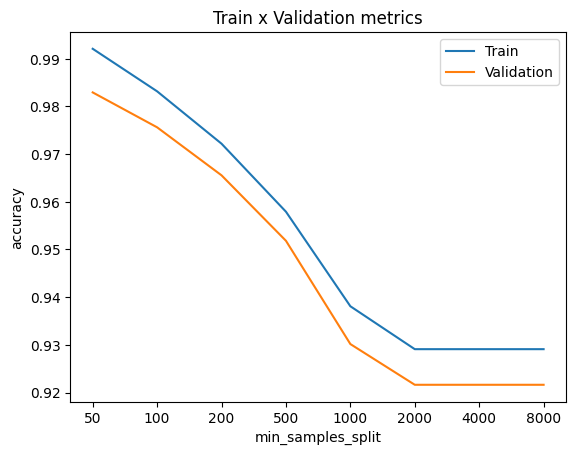

In [26]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

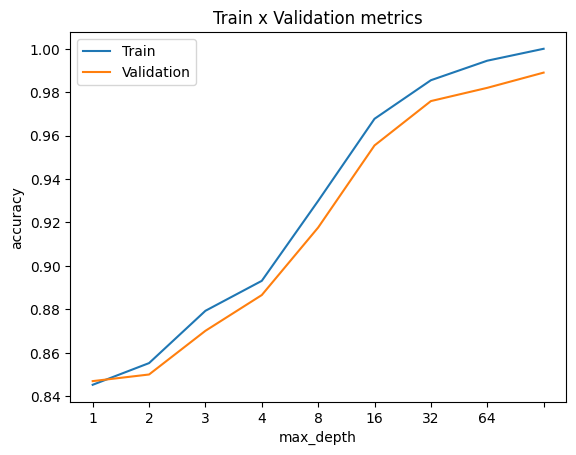

In [27]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

#### Final Model, using min sample split = 50 and max depth = 32

In [28]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 32,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [29]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9804
Metrics validation:
	Accuracy score: 0.9720


# Random Forest

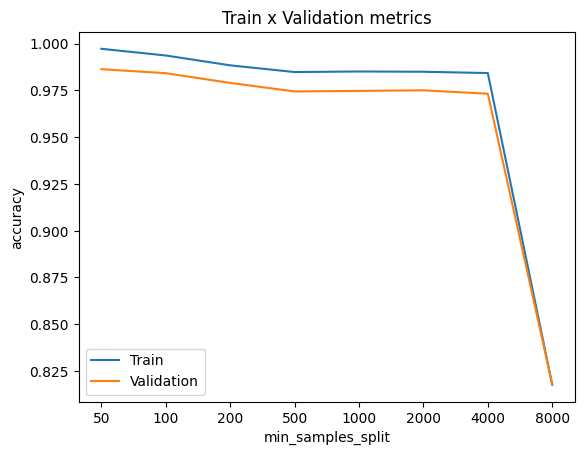

In [30]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train.values.ravel()) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

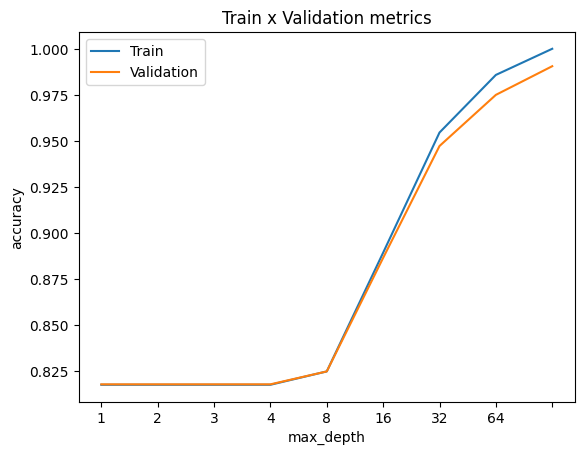

In [31]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train.values.ravel()) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

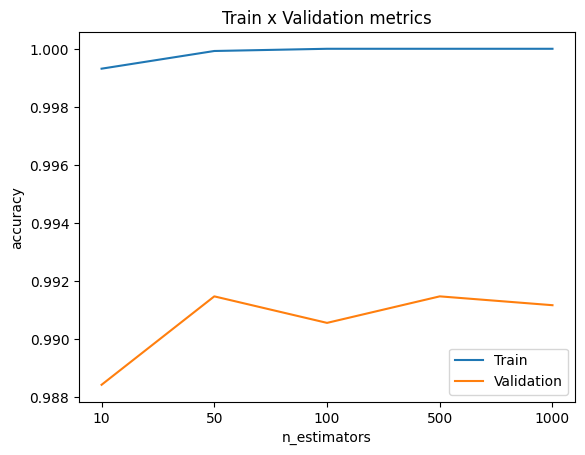

In [32]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train.values.ravel()) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

#### Final Model, using N-estimators = 50, max depth = 64, min samples split=50

In [33]:
random_forest_model = RandomForestClassifier(n_estimators = 50,
                                             max_depth = 64, 
                                             min_samples_split = 50).fit(X_train,y_train.values.ravel()) 

In [34]:
# print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")
predictions_test = random_forest_model.predict(X_test)
accuracy_test = accuracy_score(predictions_test,y_test)
precision_test = precision_score(predictions_test,y_test)
recall_test = recall_score(predictions_test,y_test)
f1_test = f1_score(predictions_test,y_test)

print(f'Test Dataset Accuracy: {accuracy_test:0.4f}')
print(f'Test Dataset Precision: {precision_test:0.4f}')
print(f'Test Dataset Recall: {recall_test:0.4f}')
print(f'Test Dataset F1: {f1_test:0.4f}')

Test Dataset Accuracy: 0.9742
Test Dataset Precision: 0.8692
Test Dataset Recall: 0.9934
Test Dataset F1: 0.9271


In [35]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9804
Metrics validation:
	Accuracy score: 0.9720


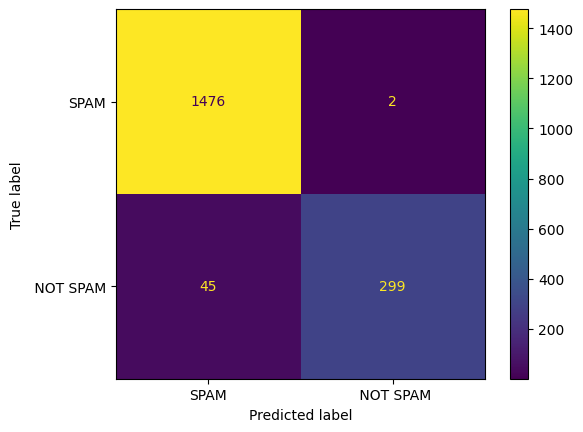

In [36]:
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(cm, display_labels=['SPAM',' NOT SPAM'])
disp.plot()
plt.show()

# Manually entered Spam Messages

In [37]:
def is_spam(text):
    processed = preprocess_text(text).split()
    arr = np.zeros(len(features), dtype = bool)
    for i,text in enumerate(features):
        if text in processed:
            arr[i] = True
    data = dict(zip(features,arr))
    # print(data)
    df_new = pd.DataFrame(data, index=[0])
    # print(df_new)
    return random_forest_model.predict(df_new)[0]

In [38]:
# text = "get a chance to win 100! join now!"
# text = "click here to win prizes"
# text = "here na me, where na u?"
# text = "the quick brown fox jumps over the lazy dog into the river"
text = "Receive 100P once use your number to register on:Filbet.com. No deposit,you may withdraw once the turnover reaches 1x. No Messages? Send STOP 10559 to 225687."
# text = "Congrats! You've won a $500 gift card. Click the link to claim your prize now:"
# text = "Hi, I saw your profile online. I would love to chat! Let's connect here: http://bit.ly/asfasdf"
# text = "Breaking: Prices are dropping! Save up to 70% only today. Shop now: http://bit.ly/asfasdf1"
# text = "You are the lucky winner of our monthly raffle! Claim your $1,000 cash prize now:http://bit.ly/asfasdf2"

print(is_spam(text))

True


# Check vs Actual Spam Messages In Our Phones

In [39]:
df_lt5 = pd.read_csv('./data/lt5_messages.csv', encoding='Latin')
# print(df_lt5.head())
sms = df_lt5['text'].to_list()
# print(sms)
processed = [preprocess_text(x) for x in sms]
# print(processed)
values = []
for item in processed:
    arr = np.zeros(len(features), dtype = bool)
    for i,text in enumerate(features):
        if text in item.split():
            arr[i] = True
    values.append(np.copy(arr))
df_lt5_oh = pd.DataFrame.from_records(values, columns = features)
df_lt5_oh['spam_flag'] = df_lt5['spam_flag']
# print(df_lt5_oh.head())
lt5_predictions = random_forest_model.predict(df_lt5_oh[features])
y_lt5 = pd.DataFrame(df_lt5_oh['spam_flag'])

In [40]:
accuracy_test = accuracy_score(lt5_predictions,y_lt5)
precision_test = precision_score(lt5_predictions,y_lt5)
recall_test = recall_score(lt5_predictions,y_lt5)
f1_test = f1_score(lt5_predictions,y_lt5)

print(f'Test Dataset Accuracy: {accuracy_test:0.4f}')
print(f'Test Dataset Precision: {precision_test:0.4f}')
print(f'Test Dataset Recall: {recall_test:0.4f}')
print(f'Test Dataset F1: {f1_test:0.4f}')

Test Dataset Accuracy: 0.7333
Test Dataset Precision: 0.5333
Test Dataset Recall: 0.8889
Test Dataset F1: 0.6667


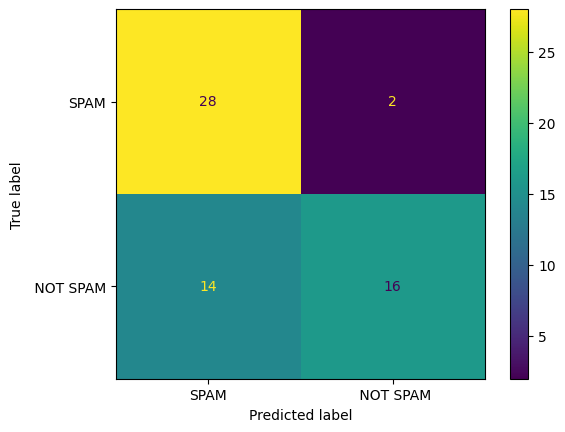

In [41]:
cm = confusion_matrix(y_lt5, lt5_predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['SPAM',' NOT SPAM'])
disp.plot()
plt.show()